In [1]:
'''
Cumulative test of RouteMap, BusModel, and TripDynamics.
'''

'\nCumulative test of RouteMap, BusModel, and TripDynamics.\n'

In [2]:
# General Imports
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
# Package Imports
import RouteMap as rm
import BusModel as bm
import TripDynamics as td
import Helper_Methods as hm

In [4]:
# Import the relevant area data:
# All Transit Stops:
stops_path = "./Data/Transit_Stops/Transit_Stops_for_King_County_Metro__transitstop_point.shp"
stops = gpd.read_file(stops_path)

# All signal lights:
signals_path = "./Data/Signals/Traffic_Signals.shp"
signals = gpd.read_file(signals_path)

# All Streets:
seattle_streets_data = "./Data/Seattle_Streets/Seattle_Streets.shp"
seattle_streets = gpd.read_file(seattle_streets_data)

In [46]:
limits

,geometry,SPEEDLIMIT
0,"LINESTRING (-122.33754 47.60612, -122.33820 47...",25.0
1,"LINESTRING (-122.34001 47.60882, -122.34092 47...",25.0
2,"LINESTRING (-122.35538 47.62637, -122.35538 47...",20.0
3,"LINESTRING (-122.35558 47.63912, -122.35557 47...",20.0
4,"LINESTRING (-122.35553 47.64562, -122.35553 47...",20.0
...,...,...
23848,"LINESTRING (-122.35313 47.52830, -122.35328 47...",20.0
23849,"LINESTRING (-122.29152 47.71435, -122.29153 47...",25.0
23850,"LINESTRING (-122.38972 47.53585, -122.38970 47...",20.0
23851,"LINESTRING (-122.32514 47.65895, -122.32512 47...",25.0


In [6]:
# make a duplicate of the stops
all_stops = stops.copy()

# make a series of the signal geometry
all_signals = signals['geometry'].reset_index(drop=True)

# get the speed limits of all streets in the dataset
limits = seattle_streets[['geometry', 'SPEEDLIMIT']]

In [7]:
# set the route number, number of samples of points
# and time period of interest
route = 101
concat_val = 6
period = 'AM'

# Import the route data
route_path = "./Data/Routes/rt{}_pts.shp".format(route)
route_raw = gpd.read_file(route_path)

# filter to the resolution of the concat value
route_concat = route_raw[::concat_val]
route_concat = route_concat.reset_index(drop=True)

# get a series of the geometry and elevation from the data
route_geometry = route_concat['geometry']
route_elevation = route_concat['Z']

# using the helper method get_stops, find all stops the route intersects with.
route_stops = hm.get_stops(all_stops, str(route))['geometry'].reset_index(drop=True)

In [47]:
# Generate a RouteMap with the RouteMap module, passing 
# the route geometry, elevation, limits, route_stops, 
# signals.
route_test_map = rm.RouteMap(route_geometry,
                             route_elevation,
                             limits,
                             route_stops,
                             all_signals,
                             debug = True)


#save the route_map as a csv for future, faster, use. 
route_test_map.get_gdf().to_csv('route_map_{}.csv'.format(route))

DEBUGGER ACTIVE
speeds assignedmainnnn
stops assigned
signals assigned


In [8]:
# Load the RouteMap from the CSV
# First, generate a routemap from the geometry and elevation
route_test_map = rm.RouteMap(route_geometry, route_elevation)

# Add in the details from the saved CSV
route_test_map = route_test_map.load_from_gdf('route_map_{}.csv'.format(route))

In [9]:
# Use in-built methods in RouteMap to get a smoothed elevation
# as a pandas series
smoothed_test_elevation = route_test_map.smooth_elevation()

# set the smoothed elevation as the route_test_map's elevation
smoothed_test_map = route_test_map.set_elevation(smoothed_test_elevation)


# convert distances using elevation to true distances traveled:
p_dist_elev = route_test_map.calc_travel_distances()
route_test_map = route_test_map.set_point_distances(p_dist_elev)

<Axes: >

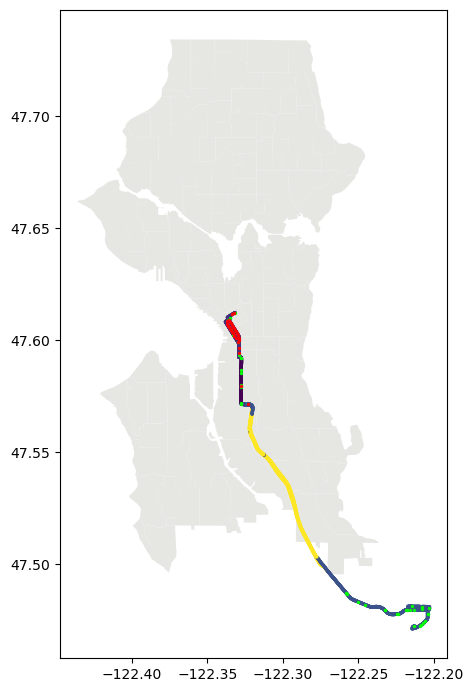

In [10]:
# Display a map of the route overlayed over area data:
# Import area map:
seattle = gpd.read_file("./Data/Census_Tracts_2000/Census_Tracts_2000.shp")

# filter out all 'water' zones in the data for clarity
seattle = seattle[(seattle['WATER'] != 1)]

# set up a figure:
fig, ax = plt.subplots(1, figsize = (5,10))

# Plot the map of the area:
seattle.plot(color="#E6E6E3", ax=ax, zorder = 0)

# get the geodtaframe of the route_map
smooth_route_gdf = smoothed_test_map.get_gdf()

# plot the route by speed limit individually
smooth_route_gdf.plot(column='speed_limit[km/s]',
                      markersize=2,
                      ax=ax,
                      alpha=1,
                      zorder=10)


# plot the stops and signals
smooth_route_gdf[smooth_route_gdf['is_stop'] == True].plot(color='lime',
                                                           markersize=2,
                                                           ax=ax,
                                                           zorder=15)
smooth_route_gdf[smooth_route_gdf['is_signal'] == True].plot(color='red',
                                                             markersize=2,
                                                             ax=ax,
                                                             zorder=20)
                                                             

In [11]:
# Creating a bus model:
# Import an acceleration profile
acc_prof_path = "./Data/Accel_Prof/acceleration.csv"
raw_acc_prof = pd.read_csv(acc_prof_path, names=['time[s]', 'accel.[g]'])

# Make a duplicate to alter
a_prof = raw_acc_prof.copy()

# Convert g's to m/s^2 and then drop g's
a_prof['accel.[m/s^2]'] = a_prof['accel.[g]'] * 9.81
a_prof = a_prof.drop(columns = ['accel.[g]'])

# Create a default bus with the acceleration profile from above,
# otherwise using the default parameters
default_bus = bm.BusModel(a_prof)

In [12]:
# Creating a trip:
# Load the ridership data
ridership_path = "./Data/Trip_Data/Zon183Unsum.csv"
kcm_ridership = pd.read_csv(ridership_path)

# filter the ridership to the selected period and route
trip_ridership = kcm_ridership[(kcm_ridership['Route']==route) & (kcm_ridership['Period']==period)]

# sort the route_ridership so the stops are in proper order
sorted_riders = trip_ridership.sort_values(by=['InOut','Trip_ID', 'STOP_SEQ', 'STOP_ID'])
sorted_riders = sorted_riders[['InOut','STOP_SEQ', 'STOP_ID', 'AveOn', 'AveOff', 'AveLd']]
sorted_riders = sorted_riders.drop_duplicates(subset=['InOut','STOP_SEQ'], keep='first')
sorted_riders = sorted_riders.drop_duplicates(subset='STOP_ID', keep='first')
sorted_riders = sorted_riders.reset_index(drop = True)
sorted_riders['Index'] = sorted_riders.index

# get the mean ridership change at each stop
sorted_riders_diff = sorted_riders['AveOn'] - sorted_riders['AveOff']

#Export the rider difference to a csv for ease of editing and access
#sorted_riders_diff.to_csv('rider_diff_{}.csv'.format(route))
sorted_riders_diff = sorted_riders_diff[:len(smooth_route_gdf[smooth_route_gdf['is_stop'] == True])]

In [41]:
import random
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import RouteMap as rm

class TripDynamics:
    def __init__(self, route_map, bus_model, bus_ridership, ridership_type='mean', seed=None):
        self._route_map = route_map
        self._bus_model = bus_model
        self._ridership_type = ridership_type
        self._rand_seed = seed
        if (self._ridership_type == 'mean'):
            self._ridership = bus_ridership
        elif (self._ridership_type == 'chance'):
            self._ridership = self.riders_from_chance(bus_ridership)
        self._route_data = self._route_map.get_gdf()
        self._route_data['riders'] = self.generate_rider_profile()
        self._route_data['bus_mass'] = self.generate_mass_profile()
        #Presently unused and innacurate
        self._route_data['f_grav'] = self._route_data['bus_mass'] * self._route_map.get_hill_accel()
        self._route_data['f_fric'] = self._route_data['bus_mass'] * self._route_map.get_fric_accel()  * self._bus_model.get_fric_coeff()
        
        self._trip_data = None
        
    
    def generate_rider_profile(self):
        '''
        generate_rider_profile generates a pandas series that contains the
        current amount of riders based on bus position
        
        Parameters:
        None
        
        Returns:
        pandas series matching length of route, with ridership numbers.
        Indicies identical to the route.
        '''
        
        # Copy the ridership changes as d_riders
        d_riders = self._ridership.copy()
        
        # get the series of stop booleans for the route
        stop_bools = self._route_data['is_stop'].copy()
        
        # create a new dataframe based on the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # default change in riders is 0
        df['d_riders'] = 0
        
        # get a list of indexes on the route that are stops
        stop_indexes = list(df[df['is_stop']==True].index)
        
        # At the stops, add the change in riders
        df.iloc[stop_indexes, df.columns.get_loc('d_riders')] = d_riders
        
        # make the cumulative riders and return it
        df['riders'] = df['d_riders'].cumsum()
        
        # Assign a class variable for ridership change
        self._ridership_change = df['d_riders']
        
        return df['riders']
    
    

    def generate_mass_profile(self):
        '''
        generate_mass_profile generates a pandas series
        containing the total bus mass at each point along
        the trip, based on the ridership information of the route.
        
        Parameters:
        None
        
        Returns:
        a pandas series containing the total bus mass
        at each point on the route, indexed the same.
        '''
        
        # Copy the stops and riders
        stop_bools = self._route_data['is_stop'].copy()
        n_riders = self._route_data['riders'].copy()
        
        # Generate a new dataframe from the stop booleans
        df = pd.DataFrame(stop_bools, columns=['is_stop'])
        
        # Add the default bus mass to the dataframe
        df['total_mass'] = self._bus_model.get_mass()
        
        # add the ridership column to the dataframe
        df['n_riders'] = n_riders
        
        # get stop indexes
        stop_indexes = df[df['is_stop']==True].index
        
        # Get the column indexes of mass and riders
        mass_col_id = df.columns.get_loc('total_mass')
        rider_col_id = df.columns.get_loc('n_riders')
        
        # Loop through each stop,
        for i in range(len(stop_indexes)):
            
            # Get the current route point index
            cur_idx = stop_indexes[i]
            
            # get the ridership value for this index
            rider_val = df.iloc[cur_idx, rider_col_id]
            
            # Set the bus model's riders to the rider value
            self._bus_model.update_riders(rider_val, 'set')
            
            # Get the mass of the bus model
            df.iloc[cur_idx:, mass_col_id] = self._bus_model.get_mass()
        
        # return the total mass series
        return df['total_mass']

    
    def get_mass_profile(self):
        return self._route_data['bus_mass']
    

    def bus_trip(self):
        '''
        bus_trip uses the route data and bus information to simulate the bus
        travelling according to a set logic, and returns the route geodataframe with new information
        on acceleration, time, and velocity.
        '''
        
        # get the route geodataframe
        route = self._route_map.get_gdf()
        
        # Get get the stop boolean column, setting the final
        # two positions to stops to help ensure proper completion.
        #route['is_stop'][:-2] == True
        
        # get the frictional acceleration profile of the route
        fric_a_prof = self._route_map.get_fric_accel()
        
        # get the hill accelerational profile of the route
        hill_a_prof = self._route_map.get_hill_accel()
        
        # get the bus model
        bus = self._bus_model
        
        # get the friction coefficient of the bus model
        bus_f_coef = bus.get_fric_coeff()
        
        # get the maximum velocity for the defined bus
        max_v = bus.max_velocity()
        
        # variable for how hard the driver presses on the brake while braking
        braking_factor = 1
        
        # define new columns for velocity, stop distance, state, and stopping distance,
        # Power needed, and time change.
        route['vel.[m/s]'] = 0
        route['acc.[m/s^2]'] = 0
        route['stop_dist[m]'] = 0
        route['stppn_dist'] = 0
        route['power_needed[W]'] = 0
        route['st'] = 0
        route['time_change[s]'] = 0
        route['inertial_force'] = 0
        route['r_change'] = abs(self._ridership_change) > 0
        
        #print(route['r_change'])
        
        # Generate empty lists to hold the same values as above.
        vel_list = []
        acc_list = []
        dist_list = []
        stp_d_ls = []
        power = []
        st_ls = []
        dt_ls = []
        
        # get the accelerational profile of the bus.
        accel_profile = bus.get_accel_profile()
        
        random.seed(42)
        # Set up a boolean for checking if the bus will stop.
        is_stopping = (random.randrange(3) == 0)
        
        # Loop through each point on the route
        for i in range(1, len(route)-1):
            
            # update the bus's mass.
            current_mass = self._route_data['bus_mass'][i]
            bus.update_mass(current_mass)
            
            # get the current point distance in meters
            point_dist = route['point_distances[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance travelled to this point in meters
            cum_dist = route['cumulative_distance[km]'][i]*1000 # convert to meters
            
            # get the cumulative distance column id
            cum_dist_col_id = route.columns.get_loc('cumulative_distance[km]')
            
            # get the dataframe containing the remaining points that have not been visited
            remaining_trip = route.iloc[i:]
            
            # set the distance to the stop to a dummy variable of 0
            dist_to_stop = 0
            
            # set the index of the next stop to dummy variable of 0
            next_stop_index = 0
            
            # get the list of stops as defined by the distance between each stop on the route,
            #including signals, in meters
            stops_remain = remaining_trip[((remaining_trip['is_stop'] == True) & remaining_trip['r_change'] == True) | ((remaining_trip['is_signal'] == True) & is_stopping)]['cumulative_distance[km]'].reset_index(drop=True)*1000 #convert to meters

            # if there are remaining stops,
            if (len(stops_remain) != 0):
                
                # set the distance to the stop to be the difference between the stop distance
                # and cumulative distance
                dist_to_stop = stops_remain[0]-cum_dist # meters
                
                # set the next stop index, handle errors where for some reason there is no value for cumulative distance.
                next_stop_match = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000]
                if (len(next_stop_match) != 0):
                    next_stop_index = route['cumulative_distance[km]'][route['cumulative_distance[km]'] == stops_remain[0]/1000].index[0]
                else:
                    # if there's nothing, assume the next stop index is in the next 10.
                    next_stop_index = i+10
                
            # get the current velocity of the bus
            start_velocity = bus.velocity()  
            
            # get the acceleration of bus friction at the point
            a_fric = fric_a_prof[i]*bus_f_coef
            
            # get the acceleration due to gravity at the point
            a_hill = hill_a_prof[i]
            
            # combine the accelerations to get external (to the bus's motor) acceleration
            ext_a = a_fric - a_hill 
            
            # calculate the stopping distance based on the starting velocity and external acceleration
            stopping_dist = bus.get_braking_distance(start_velocity, braking_factor, ext_a) #meters
            
            # get the speed limit at current point
            point_sp_lim = route['speed_limit[km/s]'][i] * 1000 # meters
            
            # set up a variable for status
            status = ""
            d_power = 0
            d_t = 0
            
            # Driving logic: -------------------------------------------------------
            #If at rest, accelerate for the distance between this and the next point
            if (start_velocity < 0.1):
                def decision(probability): return random.random() < probability
                is_stopping = decision(1) # probability is always, currently setup for later.
                status = "accel_from_0"
                d_power, d_t = bus.accelerate_v3(point_dist, ext_a)
                
            # If the distance difference between stopping distance and distance to the stop
            # is less than half the point distance resolution, then brake
            
            elif ((dist_to_stop < (stopping_dist + point_dist))):#and (abs(self._ridership_change[next_stop_index]) > 0)):
                status = "Stopping_brake"
                d_power, d_t = bus.brake_v2(point_dist, braking_factor, ext_a)
            #elif((dist_to_stop-stopping_dist)<= point_dist):
                
            # If the starting velocity is less than the speed limit, accelerate. Margin is 1/20th of speed limit.
            elif(start_velocity < (point_sp_lim - point_sp_lim/20)):
                status = "speed_lim_accel"
                d_power, d_t = bus.accelerate_v3(point_dist, ext_a)
                
            # if the starting celocity is greater than the speed limit, 
            elif(start_velocity > (point_sp_lim+point_sp_lim/20)):
                status = "speed_lim_brk"
                # find the distance needed to reach speed limit
                b_dist = ((point_sp_lim)**2 - start_velocity**2)/2 /(bus.get_b_accel())
                # brake for that distance
                d_power, d_t = bus.brake_v2(b_dist, braking_factor, ext_a)
            else:
                status = "maintain_v"
                d_power, d_t = bus.maintain_v2(point_dist, ext_a)
            # End driving logic ---------------------------------------------------------
            
            
            # Append all the statuses and data to their lists
            st_ls.append(status)
            vel_list.append(bus.velocity())
            acc_list.append(bus.get_acceleration())
            dist_list.append(dist_to_stop)
            stp_d_ls.append(stopping_dist)
            power.append(d_power)
            dt_ls.append(d_t)
        
        # convert the lists and apply them to the respective columns
        route.iloc[1:-1, route.columns.get_loc('vel.[m/s]')] = vel_list
        route.iloc[1:-1, route.columns.get_loc('acc.[m/s^2]')] = acc_list
        route.iloc[1:-1, route.columns.get_loc('stop_dist[m]')] = dist_list
        route.iloc[1:-1, route.columns.get_loc('stppn_dist')] = stp_d_ls
        route.iloc[1:-1, route.columns.get_loc('power_needed[W]')] = power
        route.iloc[1:-1, route.columns.get_loc('st')] = st_ls
        route.iloc[1:-1, route.columns.get_loc('time_change[s]')] = dt_ls
        
        route['elapsed_time[s]'] = route['time_change[s]'].cumsum()
        
        # Set the route GDF to an instance variable, then return it.
        self._trip_data = route
        return route
    
    
    def get_all_data(self):
        '''
        get_all_data returns the dataframe generated after a trip is performed.
        Parameters:
        N/A
        Returns: 
        Dataframe of Trip data, or None if no trip has been performed.
        '''
        if (self._trip_data is None):
            print("Warning, bus_trip() method has not yet been used!")
        return self._trip_data
      
        
    def generate_ESS_profile(self):
        '''
        generate_ESS_profile() is a method to create the Energy Storage System
        power profile based on the required power. Note: This requires bus_trip()
        to be run prior.
        
        Parameters:
        N/A
        
        Returns:
        Pandas series containing required power from the ESS.
        '''
        # Get the trip data's power requirements
        power_profile = self.get_all_data()['power_needed[W]']
        
        # Apply the instance power method to the power profile.
        ESS_profile = power_profile.apply(self.calc_instance_power)
        
        # Return the profile.
        return ESS_profile
    
    
    def calc_instance_power(self, value):
        '''
        calc_instance_power takes in a power value,
        and converts it to the corresponding load on the ESS.
        
        Parameters:
        value: a power value in Watts, as an int or float.
        
        Returns:
        converted battery power as a float.
        '''
        # Get the bus model parameters.
        motor_eff = self._bus_model.get_motor_eff()
        invert_eff = self._bus_model.get_invert_eff()
        aux_eff = self._bus_model.get_auxill_efficiency()
        aux_load = self._bus_model.get_aux_load()
        regen_eff = self._bus_model.get_regen_eff()
        max_regen = -100000
        
        # set the battery power to zero.
        bat_pow = 0
        
        # Including Auxilliary load, though not strictly important at the moment. 
        if (value >= 0):
            # Discharging, converting the needed power into power battery must exert
            bat_pow = value/(motor_eff*invert_eff) + (aux_load/aux_eff)
        elif(value*regen_eff*motor_eff > max_regen):
            #charging, the regenerative braking ALL the time, max regen is 100
            bat_pow = value*regen_eff*motor_eff + (aux_load/aux_eff)
        else:
            bat_pow = max_regen + (aux_load/aux_eff)
            
            
        # Return the battery power.
        return bat_pow
    
    
    def export_trip_data(self):
        '''
        export_trip_data generates a geodataframe with the most relevant informaton for
        ease of use and understanding. For a hollistic report, get_all_data is better suited.
        
        Parameters:
        N/A
        
        Returns:
        geodataframe containing trip geometry, elevation, distance, grade, ridership, mass, velocity,
        elapsed time, and power needed in Watts. 
        '''
        # Drop non-relevant columns.
        raw_trip_data = self.get_all_data().copy()
        raw_trip_data.drop("stop_dist[m]", axis='columns', inplace=True)
        raw_trip_data.drop("stppn_dist", axis='columns', inplace=True)
        raw_trip_data.drop("power_needed[W]", axis='columns', inplace=True)
        raw_trip_data.drop("is_stop", axis='columns', inplace=True)
        raw_trip_data.drop("is_signal", axis='columns', inplace=True)
        raw_trip_data.drop("point_distances[km]", axis='columns', inplace=True)
        raw_trip_data.drop("latitude", axis='columns', inplace=True)
        raw_trip_data.drop("longitude", axis='columns', inplace=True)
        raw_trip_data.drop("speed_limit[km/s]", axis='columns', inplace=True)
        
        # Add the ESS profile.
        raw_trip_data['power_needed[W]'] = self.generate_ESS_profile()
        
        # return the trip data.
        return raw_trip_data

In [42]:
# Load the csv of the rider difference
# sorted_riders_diff = (pd.read_csv('rider_diff_22.csv', index_col=False, header=0))['0']

# generate a tripDynamics object, using the route map, bus, and ridership
# changes
test_trip_dynamic = TripDynamics(smoothed_test_map,
                                    default_bus,
                                    sorted_riders_diff)

# Run the trip
test_trip = test_trip_dynamic.bus_trip()

In [38]:
test_trip

,Unnamed: 0,geometry,elevation[km],latitude,longitude,point_distances[km],cumulative_distance[km],speed_limit[km/s],is_stop,is_signal,vel.[m/s],acc.[m/s^2],stop_dist[m],stppn_dist,power_needed[W],st,time_change[s],inertial_force,r_change,elapsed_time[s]
0,0,POINT (-122.33460 47.60971),0.043667,-122.334598,47.609714,NaN,NaN,0.011176,True,False,0.000000,0.0,0.000000,0.00000,0.000000,0,0.000000,0,True,0.000000
1,1,POINT (-122.33473 47.60966),0.043681,-122.334733,47.609657,0.014950,0.014950,0.011176,False,False,4.896613,0.0,119.618345,-0.00000,34311.970406,accel_from_0,4.036697,0,False,4.036697
2,2,POINT (-122.33487 47.60960),0.043631,-122.334867,47.609601,0.014950,0.029899,0.011176,False,False,7.536999,0.0,104.668577,7.63570,390.210918,speed_lim_accel,3.119266,0,False,7.155963
3,3,POINT (-122.33500 47.60954),0.043518,-122.335002,47.609544,0.014950,0.044850,0.011176,False,False,10.233728,0.0,89.718417,18.48142,2080.891745,speed_lim_accel,3.027523,0,False,10.183486
4,4,POINT (-122.33514 47.60949),0.043347,-122.335137,47.609488,0.014951,0.059800,0.011176,False,False,11.357006,0.0,74.767647,34.69516,657.685254,speed_lim_accel,1.972477,0,False,12.155963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3285,3285,POINT (-122.33205 47.61215),0.064079,-122.332047,47.612153,0.014960,48.541694,0.011176,False,False,8.215417,0.0,45.011100,12.67992,6373.042934,speed_lim_accel,3.027523,0,False,4259.882150
3286,3286,POINT (-122.33191 47.61221),0.063168,-122.331912,47.612210,0.014976,48.556670,0.011176,False,False,6.086540,0.0,30.034906,33.19821,-156359.714000,Stopping_brake,2.094286,0,False,4261.976436
3287,3287,POINT (-122.33178 47.61227),0.061919,-122.331777,47.612266,0.015000,48.571671,0.011176,False,False,3.645915,0.0,15.034436,23.39497,-106402.501053,Stopping_brake,3.082566,0,False,4265.059002
3288,3288,POINT (-122.33164 47.61232),0.060312,-122.331642,47.612322,0.015034,48.586705,0.011176,True,False,0.000000,0.0,0.000000,10.64300,-52876.511729,Stopping_brake,5.838313,0,True,4270.897315


Total Energy Used: 39.57463981619703 kWh


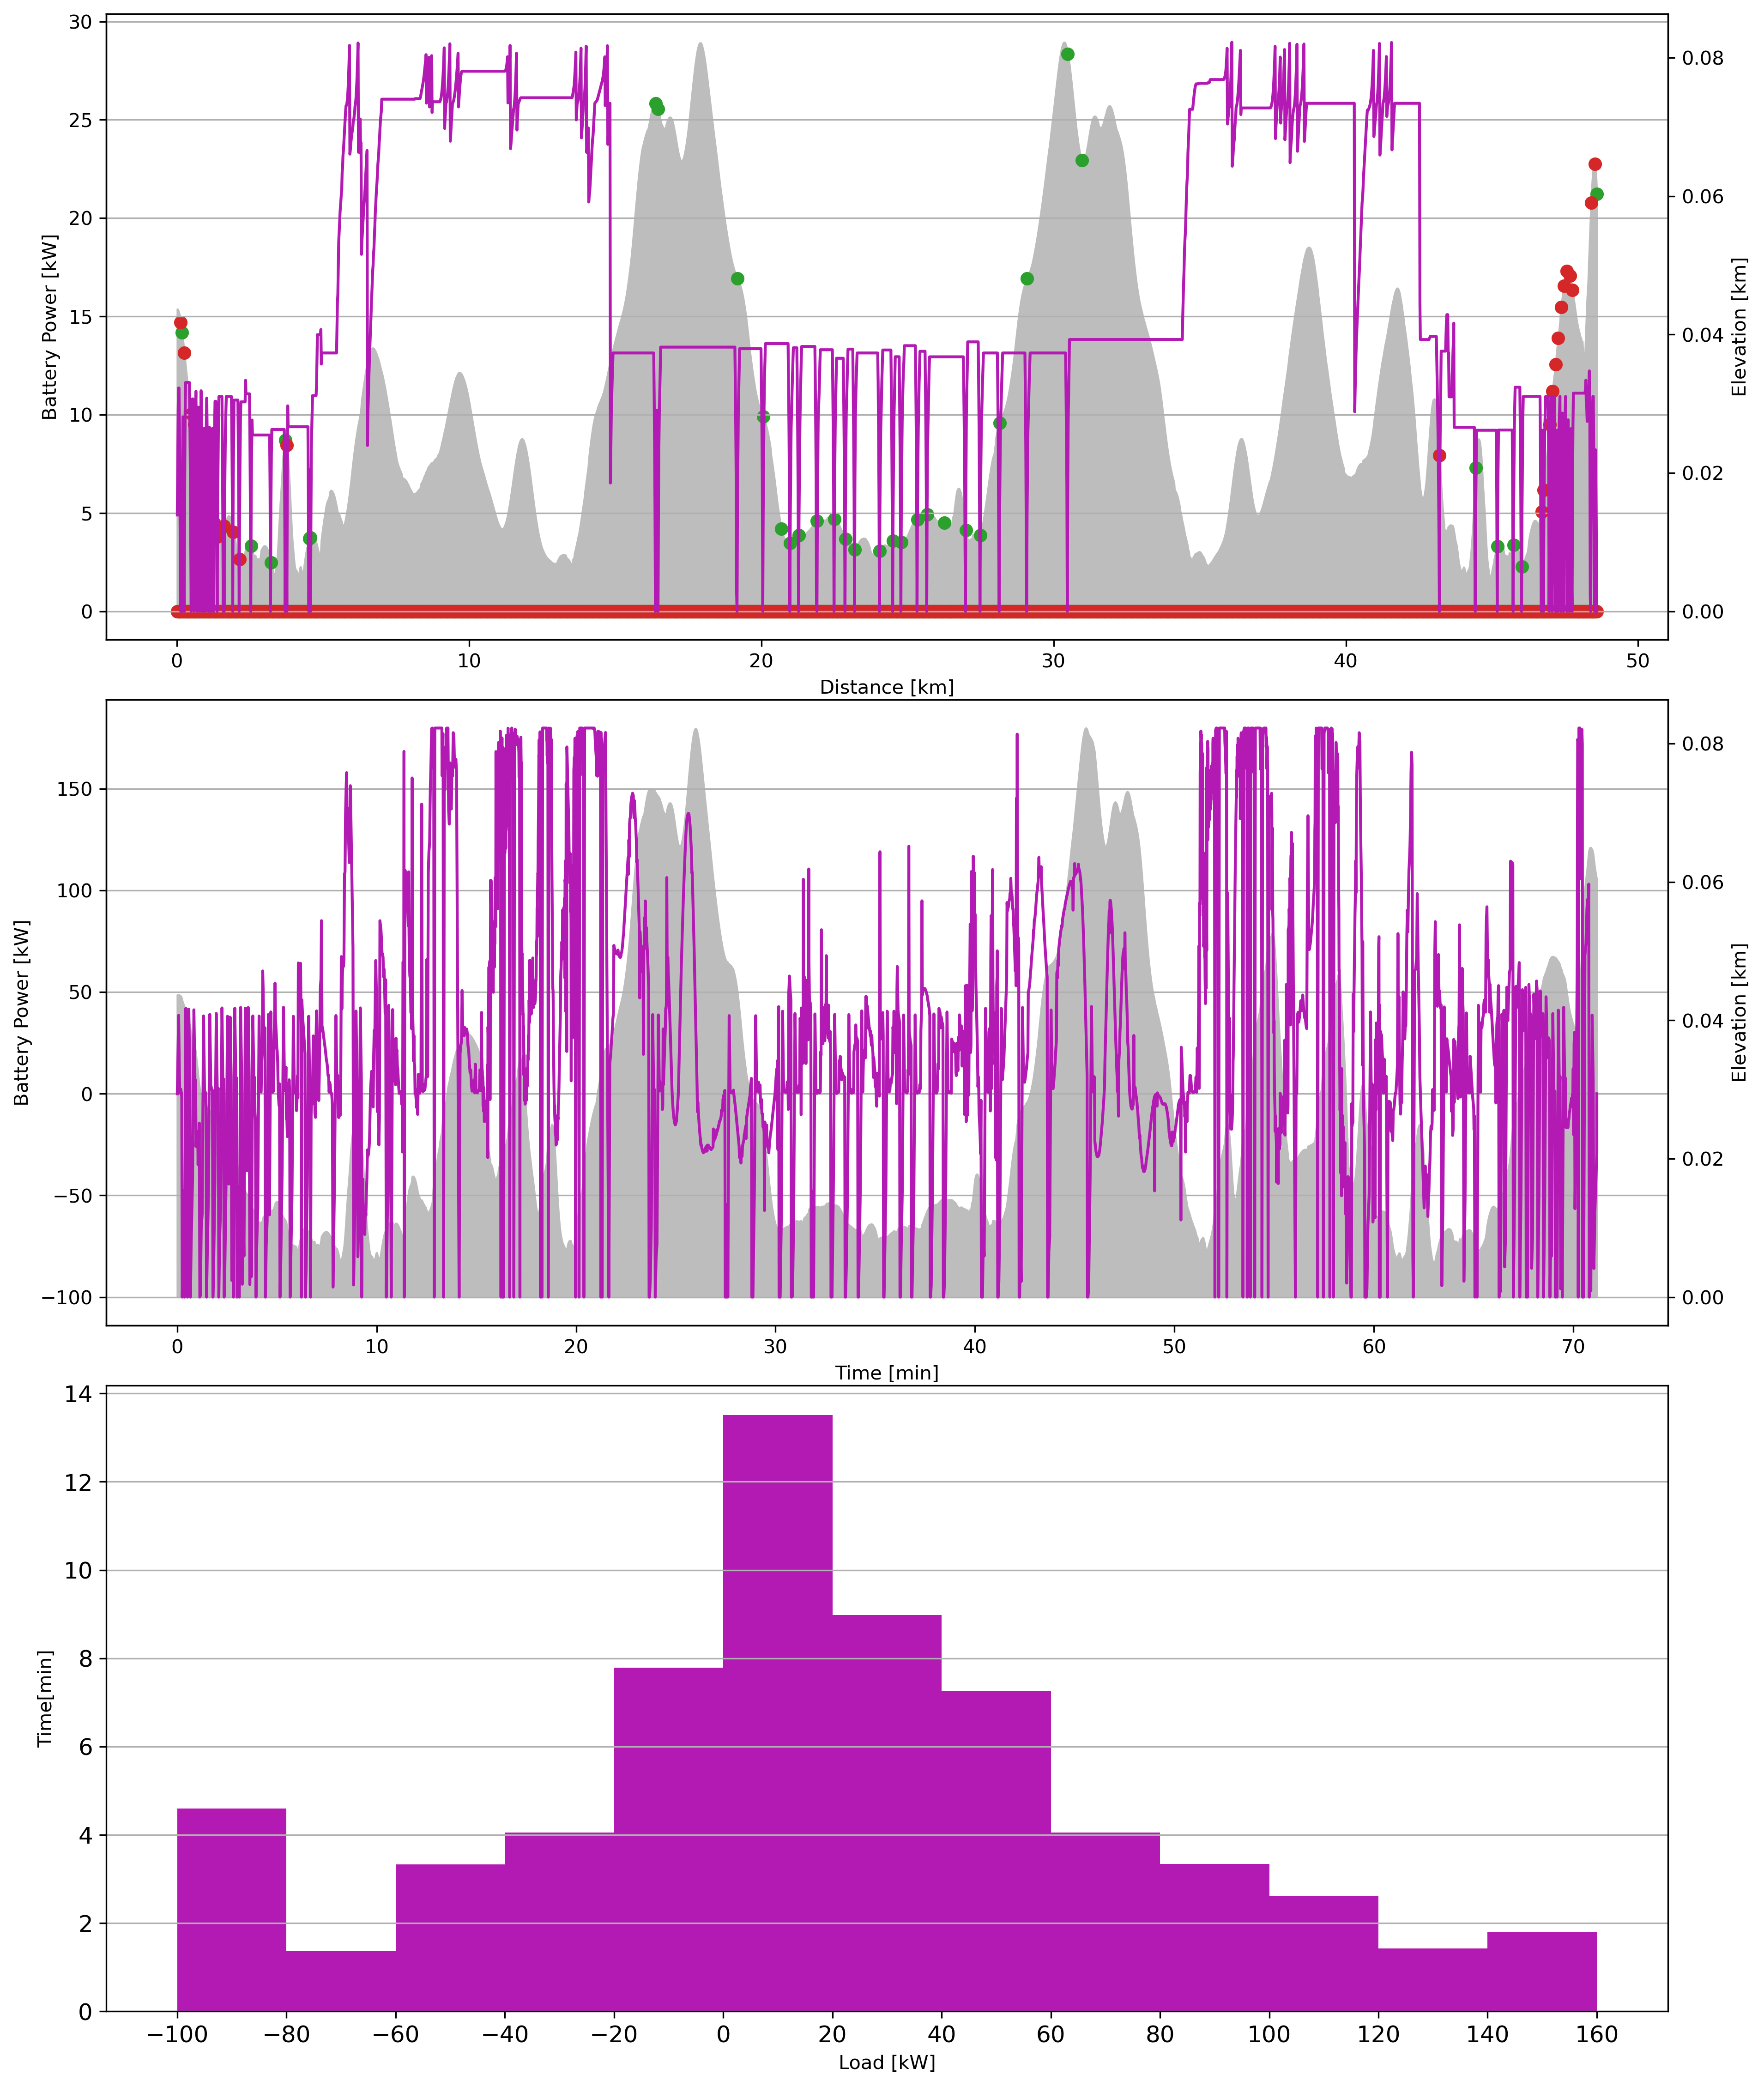

In [43]:
# plot the ESS load:
# get the ESS profile of the trip:
ess_prof = test_trip_dynamic.generate_ESS_profile()

# Convert the ess profile to kilowatts:
ess_prof = ess_prof/1000

raw_prof = test_trip['power_needed[W]']/1000

# get the distance series:
distance = test_trip['cumulative_distance[km]']

# get the elevation series:
elev = test_trip['elevation[km]']

# get the time change series:
delta_tees = test_trip['time_change[s]']

# get running time series
time = test_trip['elapsed_time[s]']

# convert time change to minutes
delta_tees = delta_tees/60
time = time/60

# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()



# Load profile (distance based)
#ax[0].plot(distance, test_trip['vel.[m/s]']*2.236, c='#b319b3')
ax[0].plot(distance, test_trip["vel.[m/s]"], c='#b319b3')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("Battery Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')
#ax[0].set_xlim(0,2)

#ax[0].plot(distance, test_trip['speed_limit[km/s]']*1000*2.236)

# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

ax_0_1.scatter(distance, test_trip['is_stop']*elev, c="tab:green")
ax_0_1.scatter(distance, test_trip['is_signal']*elev, c="tab:red")

# Load profile (time based)
ax[1].plot(time, ess_prof, c='#b319b3')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("Battery Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax[2].hist(ess_prof, color='#b319b3', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

# Create a column for the ess profile
dts = test_trip['time_change[s]']
net_energy = (ess_prof*dts).sum()/3600 # kWh
print("Total Energy Used: {} kWh".format(net_energy))

# control drag coefficient
# Control road drag
# plot each term, what value
# Elevation
# ffc of the parameters for the bus to deduce which is the issue
# reduce passenger mass/INCREASE mass

mean load: 28.128862503791858
    stdev: 106.00806164006394


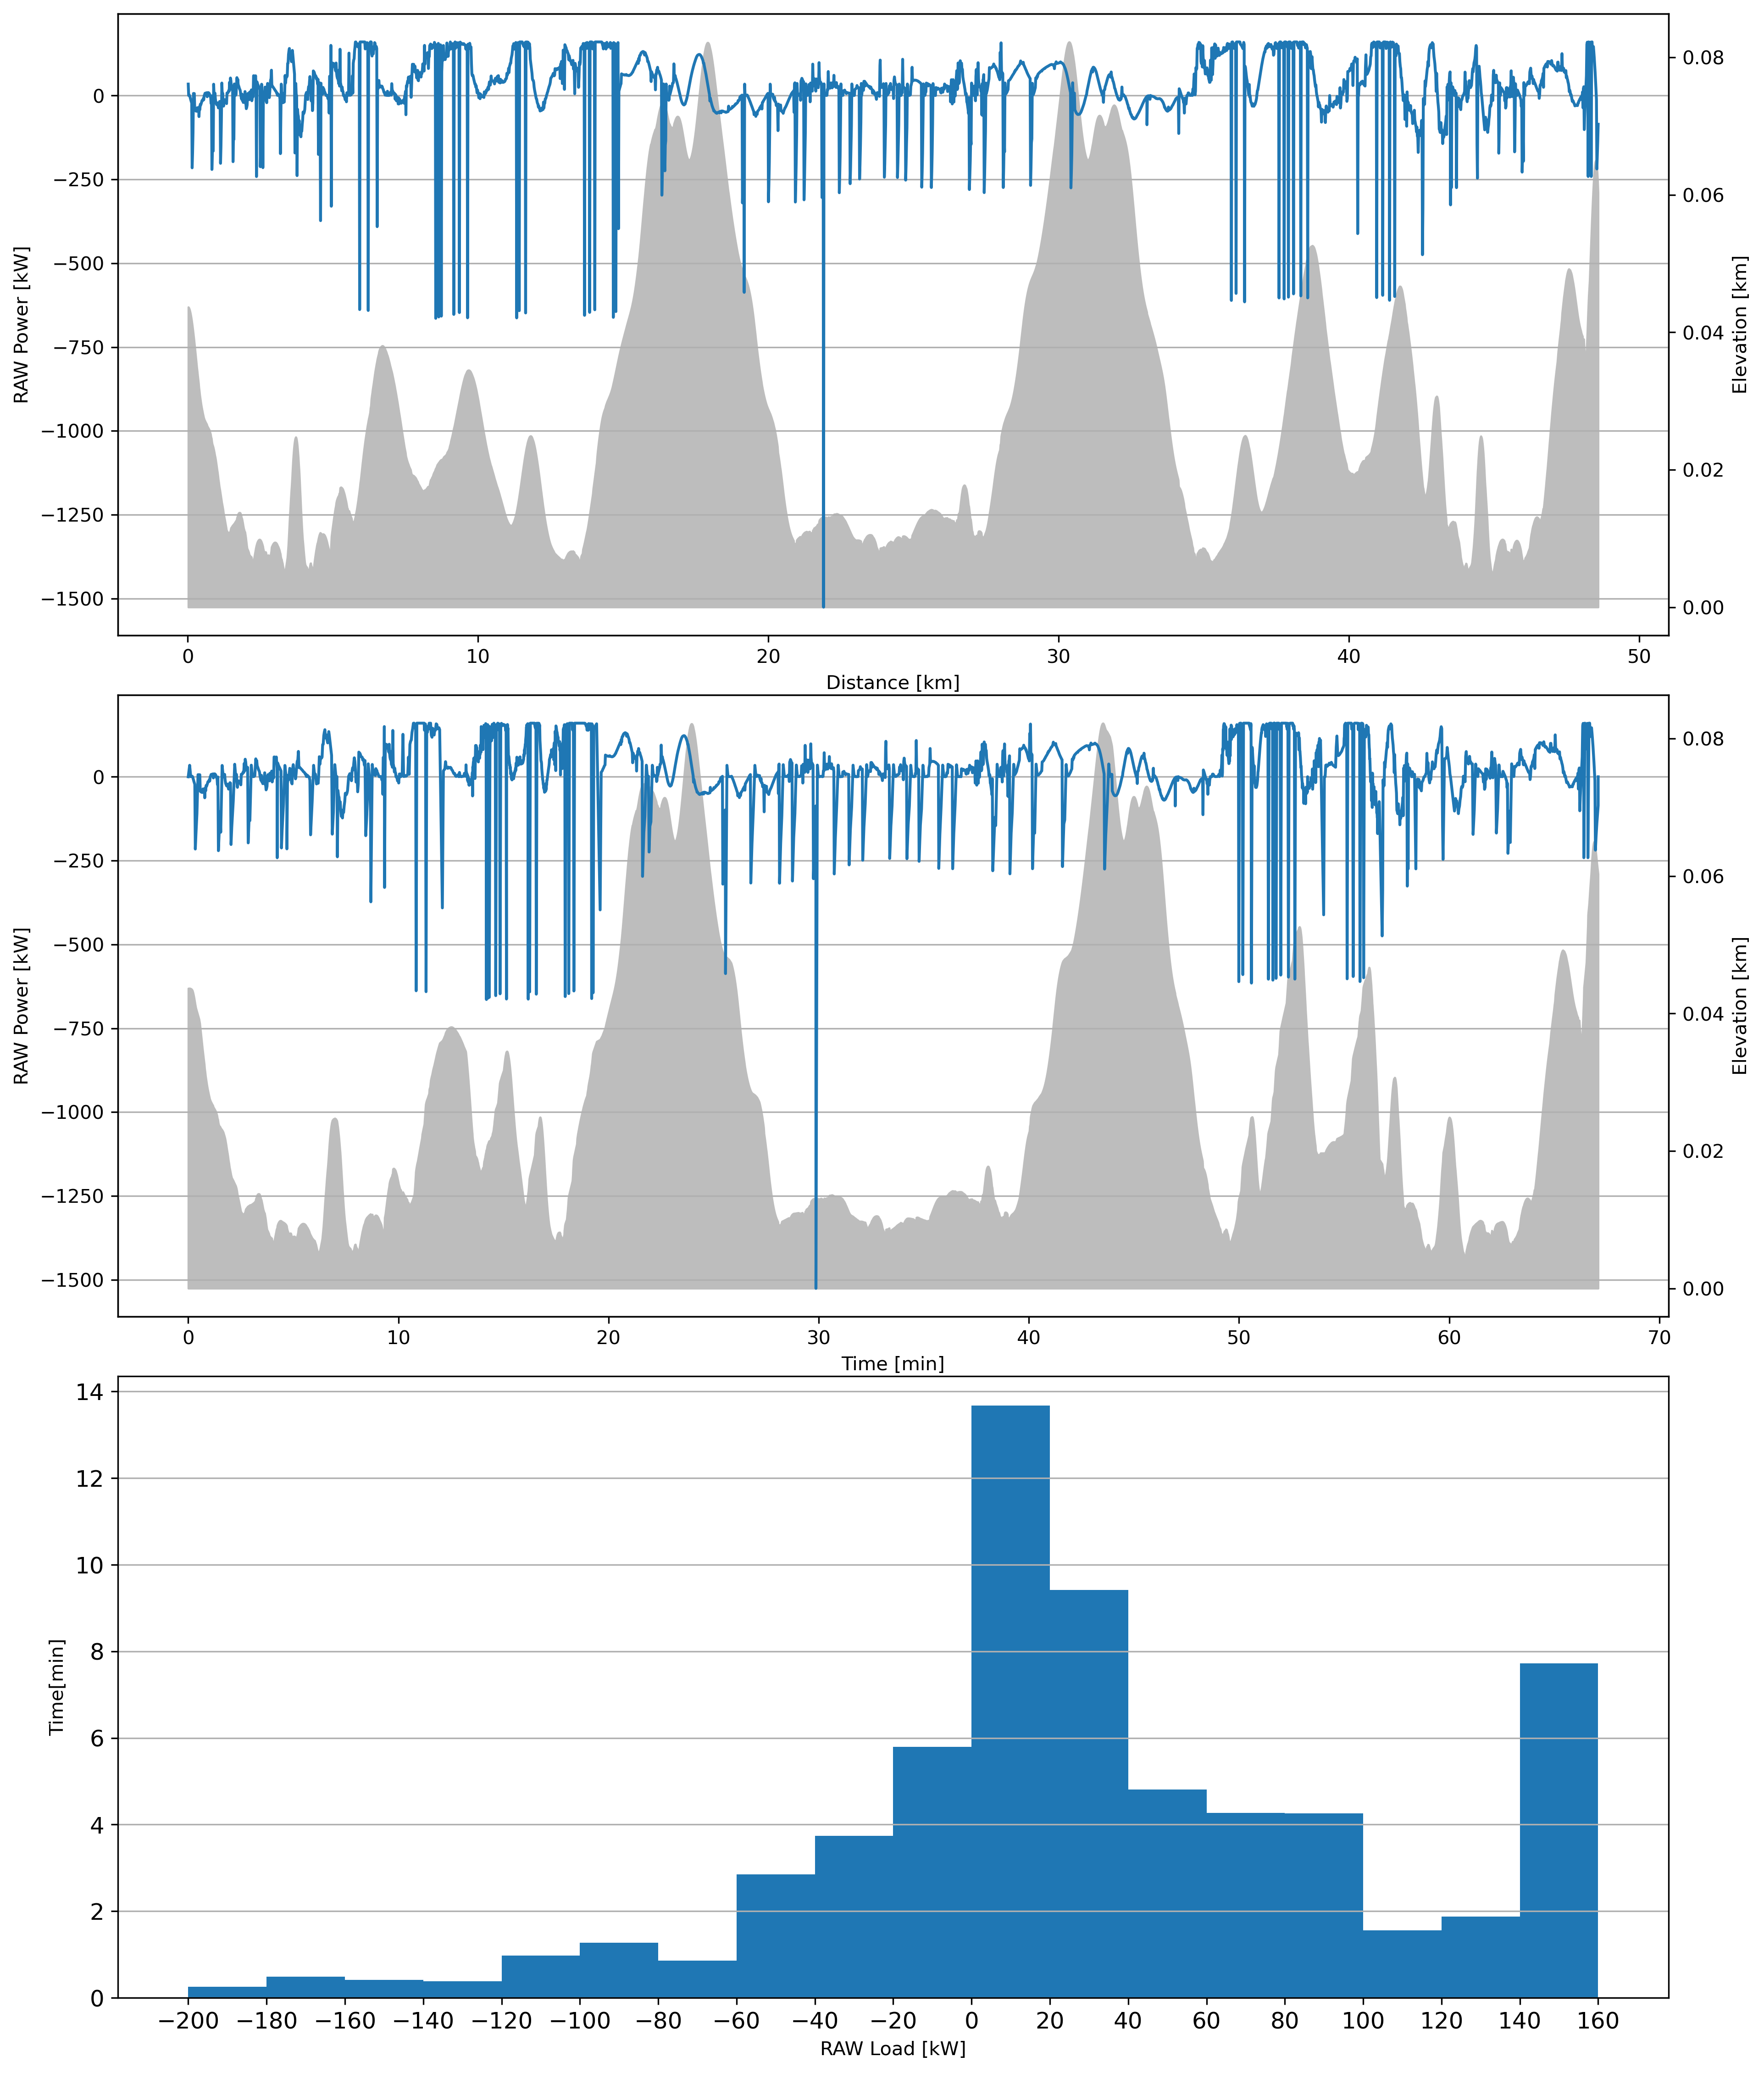

In [69]:
# Plot the raw load

# Time in hours * each bin BC we want to know kwH, 
# generate figure
fig, ax = plt.subplots(3, 1, figsize = (12, 15), dpi=300)
plt.tight_layout()

# Load profile (distance based)
ax[0].plot(distance, raw_prof, c='tab:blue')
ax[0].set_xlabel("Distance [km]")
ax[0].set_ylabel("RAW Power [kW]")
ax[0].set_zorder(1)
ax[0].set_facecolor('none')
ax[0].grid(axis='y')


# Elevation
ax_0_1 = ax[0].twinx()
ax_0_1.fill_between(distance, elev, color = '#BDBDBD')
ax_0_1.set_ylabel("Elevation [km]")
ax_0_1.set_zorder(0)

# Load profile (time based)
ax[1].plot(time, raw_prof, c='tab:blue')
ax[1].set_xlabel("Time [min]")
ax[1].set_ylabel("RAW Power [kW]")
ax[1].set_zorder(1)
ax[1].set_facecolor('none')
ax[1].grid(axis='y')

# Elevation
ax_1_1 = ax[1].twinx()
ax_1_1.fill_between(time, elev, color = '#BDBDBD')
ax_1_1.set_ylabel("Elevation [km]")
ax_1_1.set_zorder(0)


# Power Bin Histogram
bins = [-200,-180,-160,-140,-120,-100, -80, -60, -40, -20, 0, 20, 40, 60, 80, 100, 120, 140, 160]
ax[2].hist(raw_prof, color='tab:blue', bins=bins, weights=delta_tees)
ax[2].set_ylabel('Time[min]')
ax[2].set_xlabel('RAW Load [kW]')
ax[2].tick_params(labelsize=12)
ax[2].set_xticks(bins)
ax[2].grid(axis='y')

print('mean load: {}'.format(raw_prof.mean()))
print('    stdev: {}'.format(raw_prof.std()))